# $\kappa$(ET)$_2$-X の強束縛模型でのバンド計算の下準備

## 考える系の状況

$\kappa$(ET)$_2$-X を強束縛模型で計算する。
この結晶は2次元的に扱うことができ、単位胞は$x$軸の格子定数を$a$, $y$軸の格子定数を$b$とした長方形である。

この系のハミルトニアンは2次元ハバード模型

$$
\mathcal{H} = \sum_{ij}t_{ij}(c_i^{\dagger}c_j+\text{h.c.})+U\sum_i n_{\uparrow} n_{\downarrow}
$$
をもとにしたものを使う。この和の添え字はサイトを表している。
これを$\kappa$型の格子に応用したのが
$$
    \mathcal{H}_{\kappa} 
    = U \sum_{i\mu} n_{i\mu\uparrow}n_{i\mu\downarrow}
    + t_a\sum_{i\sigma}(c_{ia\sigma}^\dagger c_{ib\sigma} + \text{h.c})
    +\sum_{\langle ij \rangle \mu\mu'\sigma} 
        t_{ij}^{\mu\mu'}(c_{i\mu\sigma}^\dagger c_{j\mu'\sigma} +\text{h.c.})
$$
である。この表示

ここでの添え字は
 i 番目のダイマー にある
$ \sigma = \uparrow, \downarrow $(スピン), 
$\mu = a,b $(分子内のサイト)
といった意味である。

すると第二項はダイマー内のホッピングを表していて、第三項はそれ以外のホッピングを表している。

ただ、この表記に直す利点はあんまりないように思われる。
ひょっとしたらダイマー近似をする際に、
ダイマー内の結合性軌道と反結合性軌道に直すときには便利なのかもしれない。

ここでのパラメータは

https://doi.org/10.1038/s41467-019-12229-y

を参考にすると

$$
\begin{align*}
    t_{a} &= -0.207 \,\text{eV}\\
    t_{p} &= -0.102 \,\text{eV}\\
    t_{q} &= 0.043 \,\text{eV}\\
    t_{b} &= -0.067 \,\text{eV}\\
    U     &= 1      \,\text{eV}
\end{align*}
$$

というようにすればよいようである。

まずはオンサイトを入れずに単に解いてみる。
簡単のため長方形ではなく格子定数が 1 正方形として計算する。
生成消滅演算子はフーリエ変換すると
$$
    c_i = \frac{1}{\sqrt{N}}\sum_{\bm{k}} c_{i\bm{k}} e^{i\bm{k}\cdot\bm{R}_i}, \qquad c_i^\dagger = \frac{1}{\sqrt{N}}\sum_{\bm{k}} c_{i\bm{k}}^\dagger e^{-i\bm{k} \cdot \bm{R}_i}
$$
より、
$$
    \mathcal{H} =\sum_{\bm{k}}
        \sum_{ij} (t_{ij} e^{i\bm{k}\cdot(\bm{R}_j-\bm{R}_i)} c_{i\bm{k}}^\dagger c_{j\bm{k}} + \text{h.c.}) 
$$
各波数ごとにブロック対角化できた。

スピンを考えなくてよいので
サイトを表す添え字 $ i=0,1, \dots, 3 $ をこのようにする。

$ i = 0 $ Aダイマーの1番目のサイトにある軌道

$ i = 1 $ Aダイマーの2番目のサイトにある軌道

$ i = 2 $ Bダイマーの1番目のサイトにある軌道

$ i = 3 $ Bダイマーの2番目のサイトにある軌道

これより対角化すべきハミルトニアン行列は
$$
\mathscr{H} =
 \begin{pmatrix}
    0 &  t_a + t_b e^{ik_x} & t_q(1+e^{-ik_y}) & t_p e^{-ik_y}(1+e^{-ik_x})           \\
    t_a + t_b e^{-ik_x}  & 0 & t_p (1+e^{-ik_x}) & t_q e^{-ik_x}(1+e^{-ik_y})         \\
    t_q(1+e^{ik_y}) & t_p(1+e^{ik_x}) & 0 & t_a + t_b e^{-ik_x}                       \\
    t_p e^{ik_y}(1+e^{ik_x}) & t_q e^{ik_x}(1+e^{ik_y}) & t_a + t_b e^{ik_x} & 0      
 \end{pmatrix}
$$
となる。


オンサイト項の平均場を考える。

ハートリー項は
$$
    c_{i\mu \uparrow}^\dagger c_{i\mu \uparrow} c_{i\mu \downarrow}^\dagger c_{i\mu \downarrow}
    \simeq \braket{c_{i\mu \uparrow}^\dagger c_{i\mu \uparrow}} c_{i\mu \downarrow}^\dagger c_{i\mu \downarrow}
    + c_{i\mu \uparrow}^\dagger c_{i\mu \uparrow} \braket{c_{i\mu \downarrow}^\dagger c_{i\mu \downarrow}}
    - \cancel{\braket{c_{i\mu \uparrow}^\dagger c_{i\mu \uparrow}} \braket{c_{i\mu \downarrow}^\dagger c_{i\mu \downarrow}}}
$$
フォック項は
$$
\begin{align*}
    c_{i\mu \uparrow}^\dagger c_{i\mu \uparrow} c_{i\mu \downarrow}^\dagger c_{i\mu \downarrow}
    &=-c_{i\mu \uparrow}^\dagger c_{i\mu \downarrow} c_{i\mu \downarrow}^\dagger c_{i\mu \uparrow}\\
    &= -\braket{c_{i\mu \uparrow}^\dagger c_{i\mu \downarrow}} c_{i\mu \downarrow}^\dagger c_{i\mu \uparrow}
    -c_{i\mu \uparrow}^\dagger c_{i\mu \downarrow} \braket{c_{i\mu \downarrow}^\dagger c_{i\mu \uparrow}}
    +\cancel{\braket{c_{i\mu \uparrow}^\dagger c_{i\mu \downarrow}} \braket{c_{i\mu \downarrow}^\dagger c_{i\mu \uparrow}}}
\end{align*}
$$
となる。

ただハートリー項にすればよくて、セルフコンシステントに回す変数は
$$
    \delta = \braket{n_{i\in A\uparrow}}-\braket{n_{i\in A\downarrow}} 
    = \braket{n_{i\in B\downarrow}} - \braket{n_{i\in B\uparrow}}
$$。
というようにして反強磁性分子内磁場を表す。

ダイマーの各サイトには同数あると考えられるので(この仮定が変なのかもしれない)
$$
\begin{align*}
    \braket{n_{a1\uparrow}} = \braket{n_{a2\uparrow}} &= \frac{1}{2}\braket{n_{i\in A\uparrow}}\\
    \braket{n_{a1\downarrow}} = \braket{n_{a2\downarrow}} &= \frac{1}{2}\braket{n_{i\in A\downarrow}}\\
    \braket{n_{b1\uparrow}} = \braket{n_{b2\uparrow}} &= \frac{1}{2}\braket{n_{i\in B\uparrow}}\\
    \braket{n_{b1\downarrow}} = \braket{n_{b2\downarrow}} &= \frac{1}{2}\braket{n_{i\in B\downarrow}}\\
\end{align*}
$$
というようになり、ハミルトニアンの対角項に
$$
    \mathrm{diag}\mathscr{H} = \frac{1}{4}(3-\delta, 3-\delta,
                                            3+\delta, 3+\delta, 
                                            3+\delta, 3+\delta,
                                            3-\delta, 3-\delta)
$$
というのを足せばよい。
ただし、0-3番目の要素はアップスピン、4-7番目の要素はダウンスピンとしている。

実際には定数項となる 3/4 はエネルギーの基準点がずれるだけなので取り外すことができ、
$$
    \mathscr{H}_{\mathrm{AFM}} = \frac{U\delta}{4}\left(
        \sum_{i\in B} - \sum_{i \in A}
    \right)\sigma n_i
$$
というように反強磁性分子内場の項がよく見える形となる。

## ライブラリのインポート

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import plotly.graph_objects as go
import scipy.linalg
from matplotlib.colors import Normalize
rng = np.random.default_rng()

## $k$点周りの関数

k点の名前と座標の定義

In [2]:
k_points = {}
k_points["Γ"]       = [0.0, 0.0]
k_points["X"]        = [np.pi, 0.0]
k_points["Y"]        = [0.0, np.pi]
k_points["M"]        = [np.pi, np.pi]
k_points["Σ"]       = [np.pi/2, np.pi/2]
k_points["M'"]       = [-np.pi, np.pi]
k_points["Σ'"]      = [-np.pi/2, np.pi/2]

k 点パスを生成する関数

In [3]:
def gen_kpath(k_points, path, npoints = 50):
    k_path = []
    labels = []
    labels_loc = []
    distances = []
    total_distance = 0.0
    for (spoint, epoint) in path :
        k_start = k_points[spoint]
        k_end   = k_points[epoint]
        # 線形補完でnpoints個のk点の生成
        segment = np.linspace(k_start, k_end, npoints)
        k_path.extend(segment)

        labels.append(spoint)
        labels_loc.append(total_distance)

        distance = np.linalg.norm(np.array(k_end)-np.array(k_start))
        segment_dist = np.linspace(total_distance, total_distance+distance, npoints)
        distances.extend(segment_dist)
        total_distance += distance

    labels.append(path[-1][1])
    labels_loc.append(total_distance)

    return k_path, labels, labels_loc, distances

## 状態密度を求める関数

In [4]:
def DensityOfState(E, enes, sigma2 = 0.0001):
    dos = []
    for e in E:
        dos.append(np.sum(np.exp(-(e-enes)**2 / 2 / sigma2 ) / np.sqrt(2 * np.pi * sigma2)))
    dos = np.array(dos)
    dos /= np.sum(dos)
    return dos

## ハミルトニアンの定義

In [111]:
def Hamiltonian(kx, ky, U=0.0, Delta=0.8):
    # ホッピングパラメータ
    ta = -0.207
    tb = -0.067
    tp = -0.102
    tq = 0.043
    # スピンのプロットができるようになったら各ホッピングの果たしている役割を見るために t = 0 としてみたい
    # tb = 0
    # tp = 0
    # tq = 0

    # ホッピング項
    H = np.zeros((8,8), dtype=np.complex128)
    H[0,1] = ta + tb*np.exp(1j*kx)                          # A1up   from A2up
    H[0,2] = tq * (1 + np.exp(-1j*ky))                      # A1up   from B1up
    H[0,3] = tp * np.exp(-1j*ky) * (1 + np.exp(-1j*kx))     # A1up   from B2up

    H[1,2] = tp * (1 + np.exp(-1j*kx))                      # A2up   from B1up
    H[1,3] = tq * np.exp(-1j*kx) * (1 + np.exp(-1j*ky))     # A2up   from B2up

    H[2,3] = ta + tb*np.exp(-1j*kx)                         # B1up   from B2up

    H[4,5] = H[0,1]                                         # A1down from A2down
    H[4,6] = H[0,2]                                         # A1down from B1down
    H[4,7] = H[0,3]                                         # A1down from B2down

    H[5,6] = H[1,2]                                         # A2down from B1down
    H[5,7] = H[1,3]                                         # A2down from B2down

    H[6,7] = H[2,3]                                         # B1down from B2down

    #エルミート化
    for i in range(1,8):
        for j in range(0, i):
            H[i][j] = H[j][i].conjugate()

    # 反強磁性分子内磁場を表すハートリー項
    H[0,0] = - U * Delta / 4    # A1 up
    H[1,1] = - U * Delta / 4    # A2 up
    H[2,2] = + U * Delta / 4    # B1 up
    H[3,3] = + U * Delta / 4    # B2 up
    H[4,4] = + U * Delta / 4    # A1 down
    H[5,5] = + U * Delta / 4    # A2 down
    H[6,6] = - U * Delta / 4    # B1 down
    H[7,7] = - U * Delta / 4    # B2 down

    return scipy.linalg.eigh(H)


## バンドプロット

In [6]:
def plot_band(
        path = [("Γ", "Y"), ("Y", "M'"), ("M'", "Σ'"), ("Σ'","Γ"),
                ("Γ", "Σ"), ("Σ", "M"), ("M", "X"), ("X", "Γ")],
        U = 0, delta = 0, ef = 0):
    k_path, label, label_loc, distances = gen_kpath(k_points, path)

    bands = []
    # plt.xticks(label)
    for kxy in k_path:
        bands.append(Hamiltonian(kxy[0], kxy[1], U, delta)[0])
    bands = np.array(bands)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    # ax.set_aspect(5)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] ='Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'stix'

    ax.set_xlabel("k points")
    ax.set_ylabel("Energy (eV)")


    Ymin = np.min(bands)-0.05
    Ymax = np.max(bands)+0.05
    ax.set_xticks(label_loc, label)
    ax.set_xlim(label_loc[0], label_loc[-1])
    ax.set_ylim(Ymin, Ymax)

    ax.plot(distances, bands, color = "tab:green")
    ax.vlines(label_loc[1:-1], Ymin,Ymax, "grey", "dashed")
    ax.hlines(ef, distances[0], distances[-1], "grey")
    ax.set_title("$E_f$ = {:.2f}".format(ef))

    plt.show()

In [7]:
# 参考 https://qiita.com/okumakito/items/3b2ccc9966c43a5e84d0

def plot3d_band(enes, k_mesh, kx, ky, ef):
    fig = go.Figure()

    contours = dict(
        x=dict(highlight=False, show=True, color='grey', start=-3.5, end=3.5, size=0.5),
        y=dict(highlight=False, show=True, color='grey', start=-3.5, end=3.5, size=0.5),
        z=dict(highlight=False, show=False, start=-1, end = 1, size=0.5)
    )

    fig.add_trace(go.Surface(
            z=enes[:,:,0]-ef,
            x=kx,
            y=ky,
            colorscale = "jet",
            cmin=-0.6,
            cmax=0.4,
            # showscale = False,
            hoverinfo="skip",
            opacity=0.5,
            # hidesurface=True,
        )
    )
    for i in range(1, 8):
        fig.add_trace(go.Surface(
                z=enes[:,:,i]-ef,
                x=kx,
                y=ky,
                colorscale = "jet",
                cmin=-0.6,
                cmax=0.4,
                showscale = False,
                hoverinfo="skip",
                contours=contours,
                opacity=0.5,
                # hidesurface=True,
            )
        )
    fig.add_trace(go.Surface(
            z=np.zeros((k_mesh,k_mesh)),
            x=kx,
            y=ky,
            colorscale = "jet",
            cmin=-0.6,
            cmax=0.4,
            # showscale = False,
            hoverinfo="skip",
            opacity=0.5,
            # hidesurface=True,
        )
    )

    axis = dict(visible=True)
    fig.update_scenes(
        xaxis=axis,
        yaxis=axis,
        zaxis=axis,
        aspectratio=dict(x=1,y=1,z=1.5)
    )
    fig.update_layout(
        width=800,   # グラフの幅
        height=800   # グラフの高さ
    )
    fig.show()

# $U=0$での計算

計算をする上で与えるパラメータをここに入れる。

In [8]:
Ne      = 6.0       # 単位胞内にある電子数
k_mesh  = 20        # 状態密度を求めるときのメッシュ数 つまり計算する点は k_mesh ** 2 個

## フェルミ準位と状態密度

In [9]:
# ブリュアンゾーンのメッシュの生成
kx = np.linspace(-np.pi, np.pi, k_mesh)
ky = np.linspace(-np.pi, np.pi, k_mesh)
kx, ky = np.meshgrid(kx, ky)

# メッシュの各点でのエネルギー固有値の計算
enes = np.zeros((k_mesh, k_mesh, 8))
for i in range(k_mesh):
    for j in range(k_mesh):
        enes[i][j] = Hamiltonian(kx[i][j],ky[i][j])[0]

# フェルミエネルギーを求める
# 求めたエネルギー固有値をソートして下から何番目というのを探してやればよい
sorted_enes = np.sort(enes[:,:,].flatten())
ef = sorted_enes[int(k_mesh*k_mesh*Ne)]
print(ef)

0.20394571511995213


### 状態密度のプロット

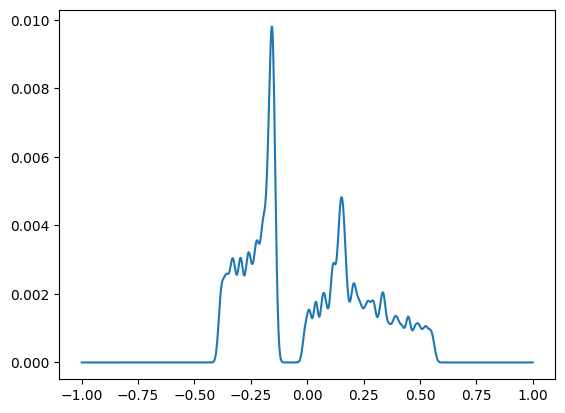

In [10]:
E = np.linspace(-1, 1, 1000)
dos = DensityOfState(E, sorted_enes)
plt.plot(E, dos)

### 累積状態密度のプロット

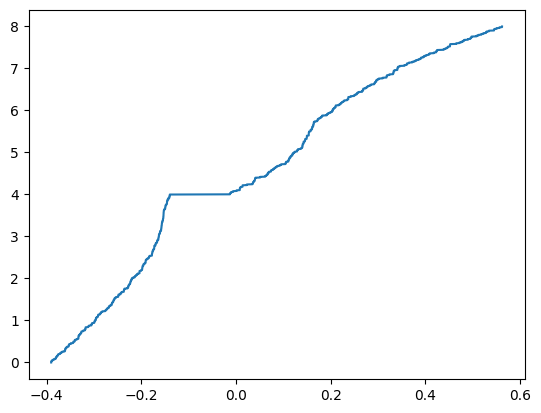

In [11]:
plt.plot(
    np.sort(enes[:,:,].flatten()),
    np.array(list(range(8*k_mesh*k_mesh)))/(k_mesh*k_mesh)
    )

## バンド図

### 経路の設定

通る経路は
$$
 \Gamma (0,0)
 \rightarrow Y(0,1)
 \rightarrow M'(-1,1)
 \rightarrow \Sigma'(-1/2,1/2)
 \rightarrow \Gamma(0,0)
 \rightarrow \Sigma(1/2,1/2)
 \rightarrow M(1,1)
 \rightarrow X(1, 0)
 \rightarrow \Gamma(0,0)
$$
である。

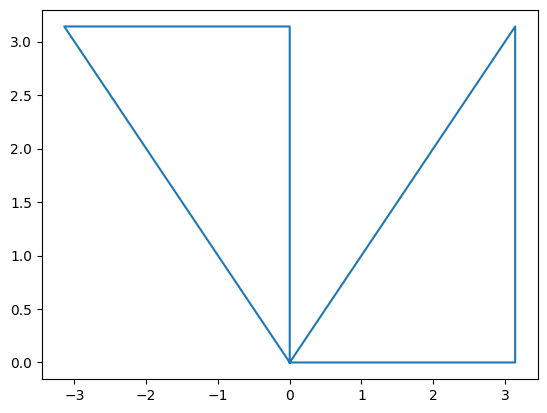

In [12]:
path = [("Γ", "Y"), ("Y", "M'"), ("M'", "Σ'"), ("Σ'","Γ"), ("Γ", "Σ"), ("Σ", "M"), ("M", "X"), ("X", "Γ")]
k_path, label, label_loc, distances = gen_kpath(k_points, path)
k_path = np.array(k_path)
plt.plot(k_path[:,0],k_path[:,1])

## 2次元プロット

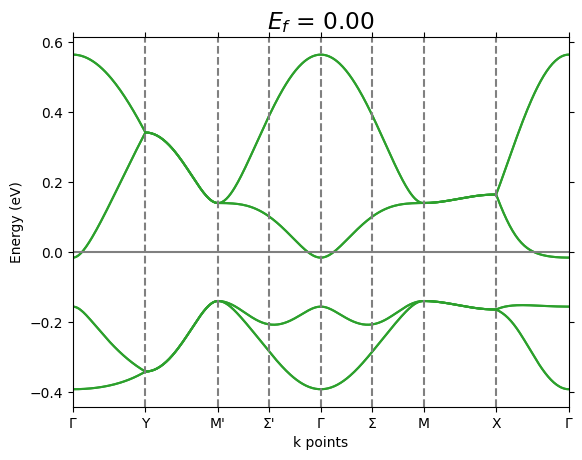

In [13]:
plot_band(path)

### 3D プロット

In [14]:
plot3d_band(enes, k_mesh, kx, ky, ef)

# $U \neq 0$ での計算

## セルフコンシステント計算

### 関数

In [26]:
def calc_delta(N_site):
    delta = ((N_site[0] + N_site[1]) - (N_site[2] + N_site[3]) - (N_site[4] + N_site[5]) + (N_site[6] + N_site[7])) / 2
    #         A1_up       A2_up         B1_up       B2_up         A1_down     A2_down       B1_down     B2_down
    return delta

def Steffensen(array):
    return array[-3]-(array[-3]-array[-2])**2 / (array[-3] - 2*array[-2] + array[-1])

In [100]:
class SCF_loop:
    def __init__(self):
        self.N_site_scf = np.array([
                        [1.15, 1.15, 0.35, 0.35, 0.35, 0.35, 1.15, 1.15]])
        self.Ef_scf     = np.array([0.2])
        # self.Ntot_scf   = np.array([6.0])
        self.Delta_scf  = np.array([0])
        self.Etot_scf   = np.array([0.8])
        self.U          = 0
        self.delta      = 0
        self.ef         = 0



    def calc(self, U = 0, iteration = 100, k_mesh = 20, Ne = 6.0, err = 1e-6):
        if(self.Ef_scf.size > 1):
            print("SCF calculation was already done.")
            return
        self.U  = U
        kx = np.linspace(-np.pi, np.pi, k_mesh)
        ky = np.linspace(-np.pi, np.pi, k_mesh)
        kx, ky = np.meshgrid(kx, ky)

        # ここから自己無頓着方程式のループになる
        # Steffensen の反復法
        for scf_iteration in range(iteration):
            for m in range(2):
                # scf で求める値の初期化
                enes   = np.array([])
                nsite  = np.zeros((8))
                etot   = 0.0
                # ntot   = 0.0

                Ef      = self.Ef_scf[-1]
                N_site  = self.N_site_scf[-1]
                Delta   = calc_delta(N_site)

                # ブリュアンゾーン内の全探査
                for i in range(k_mesh):
                    for j in range(k_mesh):
                        eigenEnergy, eigenState = Hamiltonian(kx[i][j],ky[i][j], U, Delta)
                        enes = np.append(enes, eigenEnergy)

                        # フェルミ分布で重みづけして足す。今は絶対零度なので階段関数になってる。
                        for l in range(8):
                            if (eigenEnergy[l] < Ef) :
                                nsite += np.abs(eigenState[:,l])**2
                                # ntot  += 1
                                etot  += eigenEnergy[l]

                # 規格化して足す
                nsite /= k_mesh * k_mesh
                self.N_site_scf = np.vstack((self.N_site_scf, nsite))

                self.Delta_scf = np.append(self.Delta_scf,calc_delta(nsite))

                # ntot /= k_mesh * k_mesh
                # self.Ntot_scf = np.append(self.Ntot_scf, ntot)

                etot /= k_mesh * k_mesh
                self.Etot_scf = np.append(self.Etot_scf, etot)

                # フェルミエネルギーを求める
                # 求めたエネルギー固有値をソートして下から何番目というのを探してやればよい
                sorted_enes = np.sort(enes)
                ef = sorted_enes[int(k_mesh*k_mesh*Ne)-1]
                self.Ef_scf = np.append(self.Ef_scf, ef)

            nsite = Steffensen(self.N_site_scf)
            self.N_site_scf = np.delete(self.N_site_scf,[-1,-2],0)
            self.N_site_scf = np.vstack((self.N_site_scf, nsite))

            delta = Steffensen(self.Delta_scf)
            self.Delta_scf = np.delete(self.Delta_scf,[-1,-2])
            self.Delta_scf = np.append(self.Delta_scf, delta)

            # ntot = Steffensen(self.Ntot_scf)
            # self.Ntot_scf = np.delete(self.Ntot_scf,[-1,-2])
            # self.Ntot_scf = np.append(self.Ntot_scf, ntot)

            etot = Steffensen(self.Etot_scf)
            self.Etot_scf = np.delete(self.Etot_scf,[-1,-2])
            self.Etot_scf = np.append(self.Etot_scf, etot)

            ef = Steffensen(self.Ef_scf)
            self.Ef_scf = np.delete(self.Ef_scf,[-1,-2])
            self.Ef_scf = np.append(self.Ef_scf, ef)


            if((np.abs(self.Delta_scf[-1]-self.Delta_scf[-2]) < err)
               and (np.abs(self.Ef_scf[-1]-self.Ef_scf[-2]) < err)) :
                print(f"SCF loop converged at {err} precision when U = {self.U}")
                self.delta = self.Delta_scf[-1]
                self.ef    = self.Ef_scf[-1]
                return

        print(f"SCF loop didn't converge at {err} precision when U = {self.U}")



    def plot_Nsite(self):
        plt.figure(figsize=[12.8,4.8])
        plt.subplot(121)
        for i in [0, 1, 6, 7]:
            plt.plot(self.N_site_scf[:,i], label = "site {:d} = {:.3f}".format(i, self.N_site_scf[-1, i]))
        plt.legend()
        plt.subplot(122)
        for i in [2, 3, 4, 5]:
            plt.plot(self.N_site_scf[:,i], label = "site {:d} = {:.3f}".format(i, self.N_site_scf[-1, i]))
        plt.legend()
        plt.show()



    def plot_scf(self):
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel("scf loop")

        ax1.set_ylabel("Delta")
        ax1.plot(self.Delta_scf, label="Delta = {:.6f}".format(self.Delta_scf[-1]), color = "tab:blue")

        ax2 = ax1.twinx()
        ax2.set_ylabel("Ef (eV)")
        ax2.plot(self.Ef_scf, label="Ef = {:.6f}".format(self.Ef_scf[-1]), color = "tab:orange")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2)

        plt.show()



    def plot_band(self,
                  path = [("Γ", "Y"), ("Y", "M'"), ("M'", "Σ'"), ("Σ'","Γ"),
                           ("Γ", "Σ"), ("Σ", "M"), ("M", "X"), ("X", "Γ")]):

        plot_band(path, self.U, self.Delta_scf[-1], self.Ef_scf[-1])


### 結果

SCF loop converged at 1e-06 precision when U = 0.6


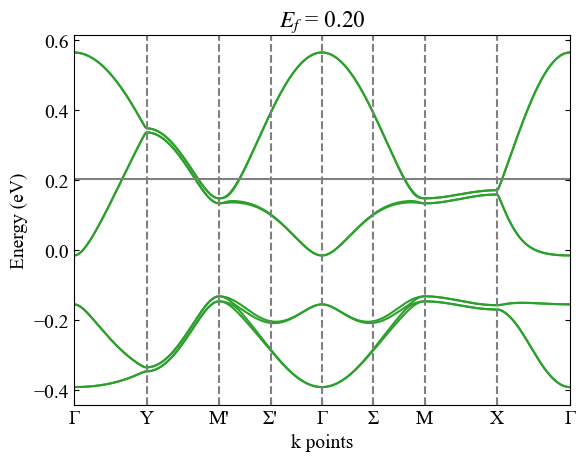

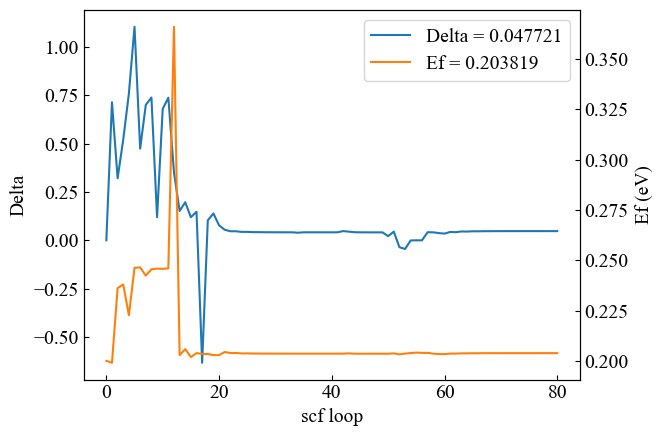

SCF loop converged at 1e-06 precision when U = 1.0


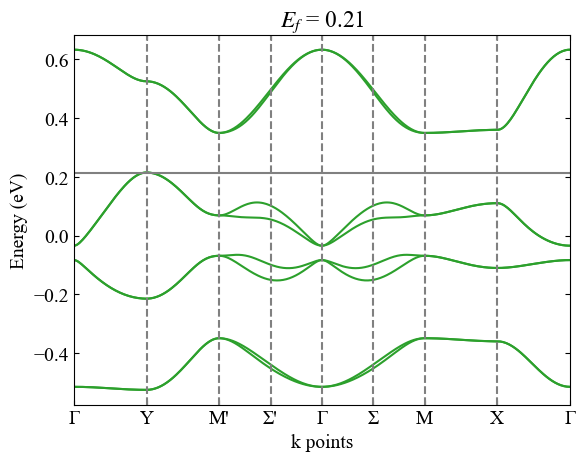

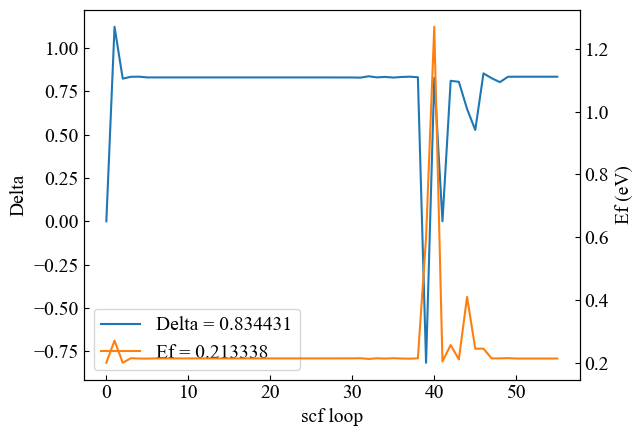

SCF loop converged at 1e-06 precision when U = 1.4


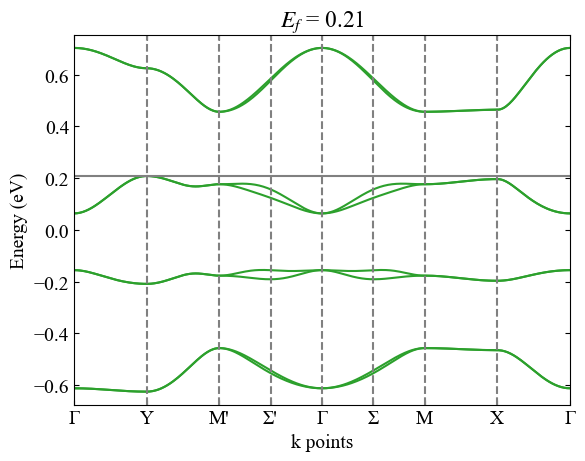

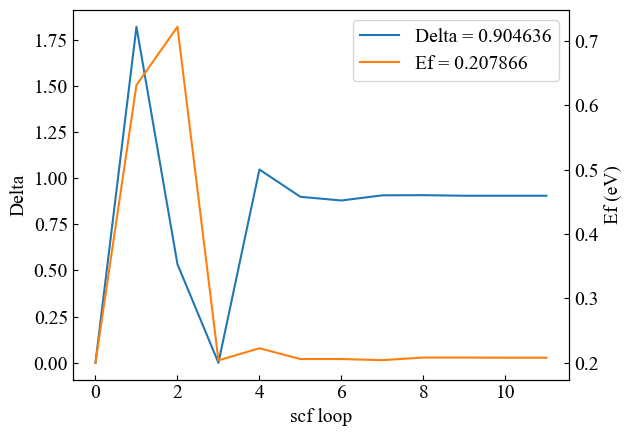

SCF loop didn't converge at 1e-06 precision when U = 1.8


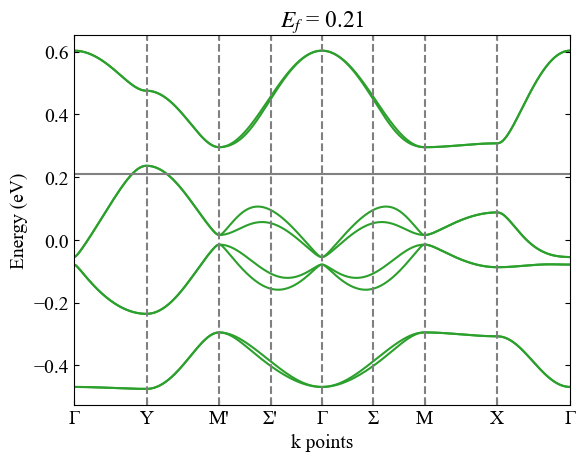

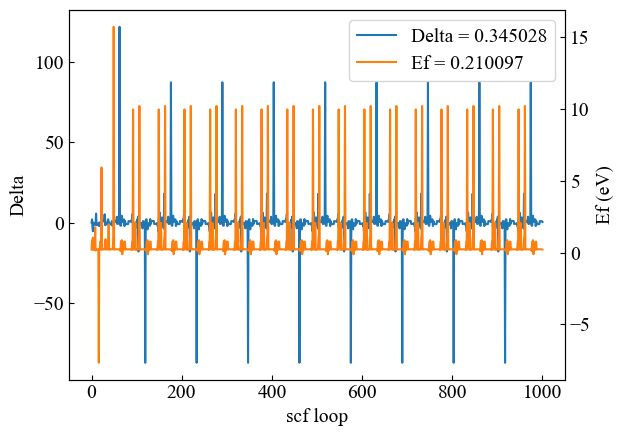

SCF loop didn't converge at 1e-06 precision when U = 2.2


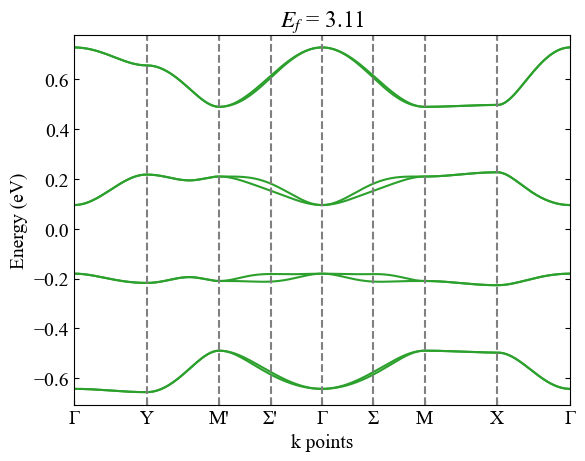

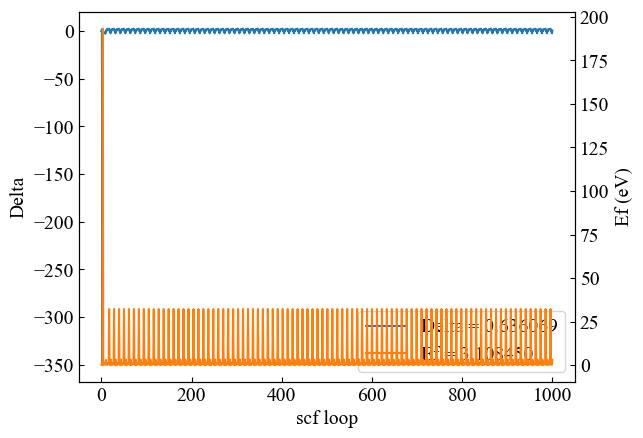

In [96]:
for U in [0.6, 1.0, 1.4, 1.8, 2.2] :
    model = SCF_loop()
    model.calc(U=U)
    model.plot_band()
    model.plot_scf()

## スピン分裂の確認

In [118]:
U       = 1.0       # オンサイト相互作用の大きさ
Ne      = 6.0       # 単位胞内にある電子数
k_mesh  = 20        # 状態密度を求めるときのメッシュ数 つまり計算する点は k_mesh ** 2 個

In [97]:
def calc_spin(eigenstate):
    spin = (np.abs(eigenstate[0])**2    # A1_up
           +np.abs(eigenstate[1])**2    # A2_up
           +np.abs(eigenstate[2])**2    # B1_up
           +np.abs(eigenstate[3])**2    # B2_up
           -np.abs(eigenstate[4])**2    # A1_down
           -np.abs(eigenstate[5])**2    # A2_down
           -np.abs(eigenstate[6])**2    # B1_down
           -np.abs(eigenstate[7])**2    # B2_donw
        )

In [108]:
# 参考 https://qiita.com/okumakito/items/3b2ccc9966c43a5e84d0

def plot3d_band_colors(enes, spins, k_mesh, kx, ky, ef):
    fig = go.Figure()

    contours = dict(
        x=dict(highlight=False, show=True, color='grey', start=-3.5, end=3.5, size=0.5),
        y=dict(highlight=False, show=True, color='grey', start=-3.5, end=3.5, size=0.5),
        z=dict(highlight=False, show=False, start=-1, end = 1, size=0.5)
    )

    fig.add_trace(go.Surface(
            z=enes[:,:,0]-ef,
            x=kx,
            y=ky,
            surfacecolor=spins[:,:,0],
            colorscale = "jet",
            cmin=-1.0,
            cmax=1.0,
            # showscale = False,
            hoverinfo="skip",
            opacity=0.5,
            # hidesurface=True,
        )
    )
    for i in range(1, 8):
        fig.add_trace(go.Surface(
                z=enes[:,:,i]-ef,
                x=kx,
                y=ky,
                surfacecolor=spins[:,:,i],
                colorscale = "jet",
                cmin=-1.0,
                cmax=1.0,
                showscale = False,
                hoverinfo="skip",
                contours=contours,
                opacity=0.5,
                # hidesurface=True,
            )
        )
    # fig.add_trace(go.Surface(
    #         z=np.zeros((k_mesh,k_mesh)),
    #         x=kx,
    #         y=ky,
    #         colorscale = "jet",
    #         cmin=-0.6,
    #         cmax=0.4,
    #         # showscale = False,
    #         hoverinfo="skip",
    #         opacity=0.5,
    #         # hidesurface=True,
    #     )
    # )

    axis = dict(visible=True)
    fig.update_scenes(
        xaxis=axis,
        yaxis=axis,
        zaxis=axis,
        aspectratio=dict(x=1,y=1,z=1.5)
    )
    fig.update_layout(
        width=800,   # グラフの幅
        height=800   # グラフの高さ
    )
    fig.show()

In [143]:
def plot_band_color(
        path = [("Γ", "Y"), ("Y", "M'"), ("M'", "Σ'"), ("Σ'","Γ"),
                ("Γ", "Σ"), ("Σ", "M"), ("M", "X"), ("X", "Γ")],
        U = 1.0, delta = 0.83, ef = 0.2):
    k_path, label, label_loc, distances = gen_kpath(k_points, path)

    bands = []
    spins = []
    # plt.xticks(label)
    for kxy in k_path:
        enes, eigenstate = Hamiltonian(kxy[0], kxy[1], U, delta)
        bands.append(enes)
        spin = []
        for l in range(8):
            sp = (np.abs(eigenstate[0,l])**2    # A1_up
                 +np.abs(eigenstate[1,l])**2    # A2_up
                 +np.abs(eigenstate[2,l])**2    # B1_up
                 +np.abs(eigenstate[3,l])**2    # B2_up
                 -np.abs(eigenstate[4,l])**2    # A1_down
                 -np.abs(eigenstate[5,l])**2    # A2_down
                 -np.abs(eigenstate[6,l])**2    # B1_down
                 -np.abs(eigenstate[7,l])**2    # B2_donw
                  )
            spin.append(sp)
        spins.append(spin)
    bands = np.array(bands)
    spins = np.array(spins)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    # ax.set_aspect(5)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] ='Times New Roman'
    plt.rcParams['mathtext.fontset'] = 'stix'

    plt.xlabel("k points")
    plt.ylabel("Energy (eV)")


    Ymin = np.min(bands)-0.05
    Ymax = np.max(bands)+0.05
    plt.xticks(label_loc, label)
    plt.xlim(label_loc[0], label_loc[-1])
    plt.ylim(Ymin, Ymax)

    for i in range(8):
        plt.scatter(distances, bands[:,i], c=spins[:,i], cmap="rainbow", vmin=-1, vmax=1, s=1)
    plt.vlines(label_loc[1:-1], Ymin,Ymax, "grey", "dashed")
    plt.hlines(ef, distances[0], distances[-1], "grey")
    plt.title("$E_f$ = {:.2f}".format(ef))
    plt.colorbar()

    plt.show()

In [105]:
model = SCF_loop()
model.calc(U=U, Ne=Ne, k_mesh=k_mesh)
delta = model.delta
ef    = model.ef
print(delta, ef)

SCF loop converged at 1e-06 precision when U = 1.0
0.8344314994363243 0.21333811103546013


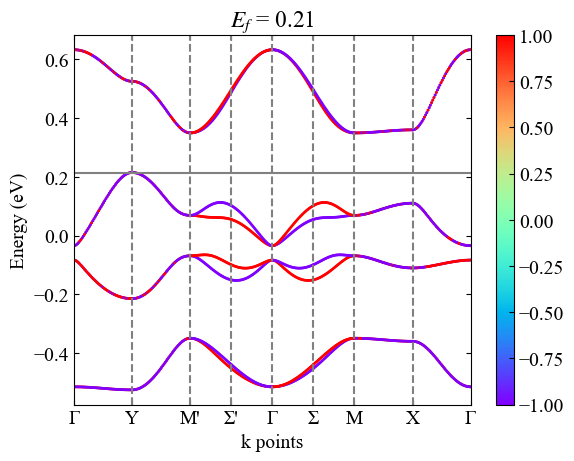

In [144]:
plot_band_color(U=1.0,delta=delta,ef=ef)

In [113]:
# ブリュアンゾーンのメッシュの生成
kx = np.linspace(-np.pi, np.pi, k_mesh)
ky = np.linspace(-np.pi, np.pi, k_mesh)
kx, ky = np.meshgrid(kx, ky)

# メッシュの各点でのエネルギー固有値の計算
enes = np.zeros((k_mesh, k_mesh, 8))
spins = np.zeros((k_mesh, k_mesh, 8))
for i in range(k_mesh):
    for j in range(k_mesh):
        enes[i][j], eigenstate = Hamiltonian(kx[i][j],ky[i][j], U, delta)
        for l in range(8):
            spin = (np.abs(eigenstate[0,l])**2    # A1_up
                   +np.abs(eigenstate[1,l])**2    # A2_up
                   +np.abs(eigenstate[2,l])**2    # B1_up
                   +np.abs(eigenstate[3,l])**2    # B2_up
                   -np.abs(eigenstate[4,l])**2    # A1_down
                   -np.abs(eigenstate[5,l])**2    # A2_down
                   -np.abs(eigenstate[6,l])**2    # B1_down
                   -np.abs(eigenstate[7,l])**2    # B2_donw
                    )
            spins[i][j][l] = spin

plot3d_band_colors(enes,spins, k_mesh, kx, ky, ef)